In [2]:
!pip install jcopdl gdown
!gdown https://drive.google.com/uc?id=1aPgQGEWnekL4MwhfoQIUUs8m2cT1Coon
!unzip /content/panorama.zip

Downloading...
From: https://drive.google.com/uc?id=1aPgQGEWnekL4MwhfoQIUUs8m2cT1Coon
To: /content/panorama.zip
25.7MB [00:00, 120MB/s] 
Archive:  /content/panorama.zip
replace data/test_label.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: data/test_label.csv     
  inflating: data/.DS_Store          
  inflating: __MACOSX/data/._.DS_Store  
  inflating: data/test/1409.jpg      
  inflating: __MACOSX/data/test/._1409.jpg  
  inflating: data/test/1347.jpg      
  inflating: __MACOSX/data/test/._1347.jpg  
  inflating: data/test/1145.jpg      
  inflating: __MACOSX/data/test/._1145.jpg  
  inflating: data/test/360.jpg       
  inflating: __MACOSX/data/test/._360.jpg  
  inflating: data/test/1192.jpg      
  inflating: __MACOSX/data/test/._1192.jpg  
  inflating: data/test/374.jpg       
  inflating: __MACOSX/data/test/._374.jpg  
  inflating: data/test/1964.jpg      
  inflating: __MACOSX/data/test/._1964.jpg  
  inflating: data/test/1958.jpg      
  inflating: __MACOSX/data/t

In [0]:
import numpy as np
import matplotlib.pyplot as plt

In [4]:
import torch
from torch import nn, optim
from jcopdl.callback import Callback, set_config

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

# Dataset & Dataloader

In [0]:
from torchvision import transforms
from torch.utils.data import DataLoader
from jcopdl.utils.dataloader import MultilabelDataset

In [0]:
bs = 64
crop_size = 224

train_transform = transforms.Compose([
    transforms.RandomRotation(15),
    transforms.RandomResizedCrop(crop_size, scale=(0.8, 1.)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize(230),
    transforms.CenterCrop(crop_size),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

train_set = MultilabelDataset("data/train_label.csv", "data/train/", transform=train_transform)
trainloader = DataLoader(train_set, batch_size=bs, shuffle=True, num_workers=4)

test_set = MultilabelDataset("data/test_label.csv", "data/test/", transform=test_transform)
testloader = DataLoader(test_set, batch_size=bs, shuffle=True)

In [7]:
label2cat = train_set.classes
label2cat

['desert', 'mountains', 'sea', 'sunset', 'trees']

# Arsitektur dan Config

In [0]:
# from torchvision.models import mobilenet_v2

# mnet = mobilenet_v2(pretrained=True)

# for param in mnet.parameters():
#     param.requires_grad = False
    
# mnet.classifier = nn.Sequential(
#     nn.Linear(1280, 5),
#     nn.Sigmoid()
# )

In [0]:
from torchvision.models import mobilenet_v2


class CustomMobilenetV2(nn.Module):
    def __init__(self, output_size):
        super().__init__()
        self.mnet = mobilenet_v2(pretrained=True)
        self.freeze()

        self.mnet.classifier = nn.Sequential(
            nn.Linear(1280, output_size),
            nn.Sigmoid()
        )
          
    def forward(self, x):
        return self.mnet(x)
    
    def freeze(self):
        for param in self.mnet.parameters():
            param.requires_grad = False
            
    def unfreeze(self):
        for param in self.mnet.parameters():
            param.requires_grad = True

In [0]:
config = set_config({
    "output_size": len(train_set.classes),
    "bs": bs,
    "crop_size": crop_size
})

## Phase 1: Adaptation (lr standard, patience kecil)

In [11]:
model = CustomMobilenetV2(config.output_size).to(device)
criterion = nn.BCELoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001)
callback = Callback(model, config, early_stop_patience=2, outdir="model")

Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/checkpoints/mobilenet_v2-b0353104.pth


In [0]:
from tqdm.auto import tqdm

def loop_fn(mode, dataset, dataloader, model, criterion, optimizer, device):
    if mode == "train":
        model.train()
    elif mode == "test":
        model.eval()
    cost = 0
    for feature, target in tqdm(dataloader, desc=mode.title()):
        feature, target = feature.to(device), target.to(device)
        output = model(feature)
        loss = criterion(output, target)
        
        if mode == "train":
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        
        cost += loss.item() * feature.shape[0]
    cost = cost / len(dataset)
    return cost



Epoch     1
Train_cost  = 0.5131 | Test_cost  = 0.3989 | 




Epoch     2
Train_cost  = 0.3679 | Test_cost  = 0.3262 | 




Epoch     3
Train_cost  = 0.3229 | Test_cost  = 0.2909 | 




Epoch     4
Train_cost  = 0.2823 | Test_cost  = 0.2669 | 




Epoch     5
Train_cost  = 0.2713 | Test_cost  = 0.2538 | 




Epoch     6
Train_cost  = 0.2568 | Test_cost  = 0.2482 | 




Epoch     7
Train_cost  = 0.2464 | Test_cost  = 0.2496 | 
==> EarlyStop patience =  1 | Best test_cost: 0.2482




Epoch     8
Train_cost  = 0.2373 | Test_cost  = 0.2338 | 




Epoch     9
Train_cost  = 0.2383 | Test_cost  = 0.2380 | 
==> EarlyStop patience =  1 | Best test_cost: 0.2338




Epoch    10
Train_cost  = 0.2307 | Test_cost  = 0.2273 | 




Epoch    11
Train_cost  = 0.2223 | Test_cost  = 0.2285 | 
==> EarlyStop patience =  1 | Best test_cost: 0.2273




Epoch    12
Train_cost  = 0.2159 | Test_cost  = 0.2235 | 




Epoch    13
Train_cost  = 0.2267 | Test_cost  = 0.2228 | 




Epoch    14
Train_cost  = 0.2162 | Test_cost  = 0.2189 | 




Epoch    15
Train_cost  = 0.2152 | Test_cost  = 0.2211 | 
==> EarlyStop patience =  1 | Best test_cost: 0.2189




Epoch    16
Train_cost  = 0.2138 | Test_cost  = 0.2145 | 




Epoch    17
Train_cost  = 0.2079 | Test_cost  = 0.2150 | 
==> EarlyStop patience =  1 | Best test_cost: 0.2145




Epoch    18
Train_cost  = 0.2159 | Test_cost  = 0.2260 | 
==> EarlyStop patience =  2 | Best test_cost: 0.2145
==> Execute Early Stopping at epoch: 18 | Best test_cost: 0.2145
==> Best model is saved at model


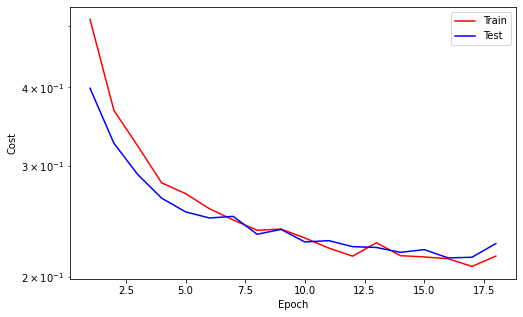

In [13]:
while True:
    train_cost = loop_fn("train", train_set, trainloader, model, criterion, optimizer, device)
    with torch.no_grad():
        test_cost = loop_fn("test", test_set, testloader, model, criterion, optimizer, device)
    
    # Logging
    callback.log(train_cost, test_cost)

    # Checkpoint
    callback.save_checkpoint()
        
    # Runtime Plotting
    callback.cost_runtime_plotting()
    
    # Early Stopping
    if callback.early_stopping(model, monitor="test_cost"):
        callback.plot_cost()
        break

## Phase 2: Fine-tuning (lr dikurangi + patience standard)

In [0]:
model.unfreeze()
optimizer = optim.AdamW(model.parameters(), lr=1e-5)

callback.reset_early_stop()
callback.early_stop_patience = 5



Epoch    19
Train_cost  = 0.1955 | Test_cost  = 0.2123 | 




Epoch    20
Train_cost  = 0.1789 | Test_cost  = 0.1990 | 


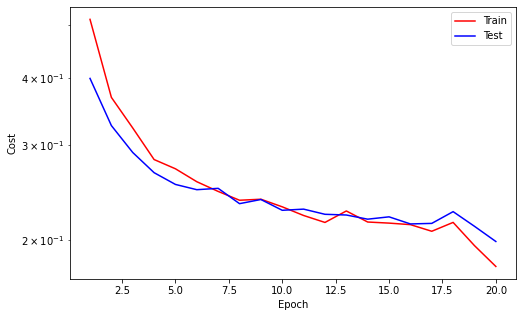



Epoch    21
Train_cost  = 0.1647 | Test_cost  = 0.1917 | 




Epoch    22
Train_cost  = 0.1605 | Test_cost  = 0.1922 | 
==> EarlyStop patience =  1 | Best test_cost: 0.1917




Epoch    23
Train_cost  = 0.1526 | Test_cost  = 0.1887 | 




Epoch    24
Train_cost  = 0.1480 | Test_cost  = 0.1930 | 
==> EarlyStop patience =  1 | Best test_cost: 0.1887




Epoch    25
Train_cost  = 0.1393 | Test_cost  = 0.1870 | 




Epoch    26
Train_cost  = 0.1351 | Test_cost  = 0.1815 | 




Epoch    27
Train_cost  = 0.1289 | Test_cost  = 0.1804 | 




Epoch    28
Train_cost  = 0.1246 | Test_cost  = 0.1784 | 




Epoch    29
Train_cost  = 0.1266 | Test_cost  = 0.1793 | 
==> EarlyStop patience =  1 | Best test_cost: 0.1784




Epoch    30
Train_cost  = 0.1202 | Test_cost  = 0.1715 | 




Epoch    31
Train_cost  = 0.1132 | Test_cost  = 0.1740 | 
==> EarlyStop patience =  1 | Best test_cost: 0.1715




Epoch    32
Train_cost  = 0.1114 | Test_cost  = 0.1713 | 




Epoch    33
Train_cost  = 0.1085 | Test_cost  = 0.1736 | 
==> EarlyStop patience =  1 | Best test_cost: 0.1713




Epoch    34
Train_cost  = 0.1010 | Test_cost  = 0.1688 | 




Epoch    35
Train_cost  = 0.1050 | Test_cost  = 0.1675 | 




Epoch    36
Train_cost  = 0.0985 | Test_cost  = 0.1650 | 




Epoch    37
Train_cost  = 0.0958 | Test_cost  = 0.1697 | 
==> EarlyStop patience =  1 | Best test_cost: 0.1650




Epoch    38
Train_cost  = 0.0919 | Test_cost  = 0.1706 | 
==> EarlyStop patience =  2 | Best test_cost: 0.1650




Epoch    39
Train_cost  = 0.0912 | Test_cost  = 0.1686 | 
==> EarlyStop patience =  3 | Best test_cost: 0.1650




Epoch    40
Train_cost  = 0.0888 | Test_cost  = 0.1706 | 


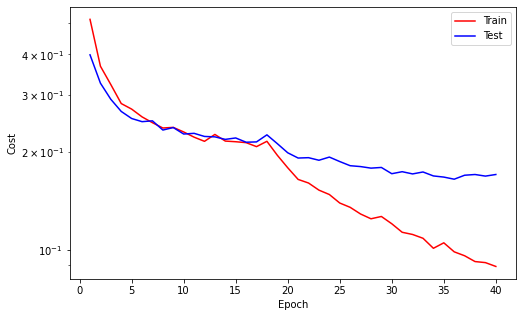

==> EarlyStop patience =  4 | Best test_cost: 0.1650




Epoch    41
Train_cost  = 0.0880 | Test_cost  = 0.1687 | 
==> EarlyStop patience =  5 | Best test_cost: 0.1650
==> Execute Early Stopping at epoch: 41 | Best test_cost: 0.1650
==> Best model is saved at model


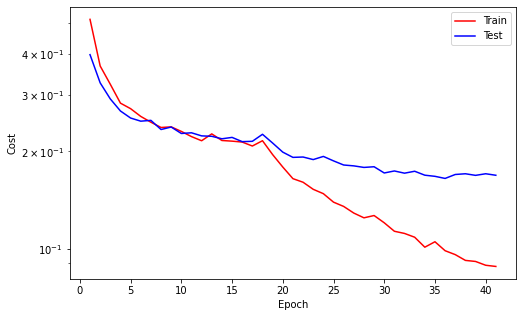

In [15]:
while True:
    train_cost = loop_fn("train", train_set, trainloader, model, criterion, optimizer, device)
    with torch.no_grad():
        test_cost = loop_fn("test", test_set, testloader, model, criterion, optimizer, device)
    
    # Logging
    callback.log(train_cost, test_cost)

    # Checkpoint
    callback.save_checkpoint()
        
    # Runtime Plotting
    callback.cost_runtime_plotting()
    
    # Early Stopping
    if callback.early_stopping(model, monitor="test_cost"):
        callback.plot_cost()
        break

# Sanity Check

In [0]:
feature, target = next(iter(testloader))
feature, target = feature.to(device), target.to(device)

In [17]:
with torch.no_grad():
    model.eval()
    output = model(feature)
    preds = (output > 0.5).to(torch.float32)
preds

tensor([[0., 0., 1., 0., 0.],
        [1., 1., 0., 0., 0.],
        [0., 0., 0., 0., 1.],
        [0., 1., 0., 0., 0.],
        [0., 1., 0., 0., 0.],
        [0., 1., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1.],
        [0., 0., 1., 0., 0.],
        [1., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [0., 0., 1., 1., 0.],
        [1., 0., 0., 0., 1.],
        [0., 0., 0., 1., 0.],
        [0., 0., 1., 1., 0.],
        [1., 0., 1., 0., 0.],
        [0., 0., 1., 0., 0.],
        [0., 0., 1., 0., 0.],
        [1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 1.],
        [0., 0., 1., 1., 0.],
        [0., 1., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 1.],
        [0., 0., 1., 1., 0.],
        [1., 0., 1., 0., 0.],
        [0., 0., 0., 0., 1.],
        [0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 1.],
        [0

In [0]:
def convert_to_label(x):
    return [label for pred, label in zip(x, label2cat) if pred==1]

def inverse_norm(img):
    img[0, :, :] = img[0, :, :] * 0.229 + 0.485
    img[1, :, :] = img[1, :, :] * 0.224 + 0.456
    img[2, :, :] = img[2, :, :] * 0.225 + 0.406
    return img    

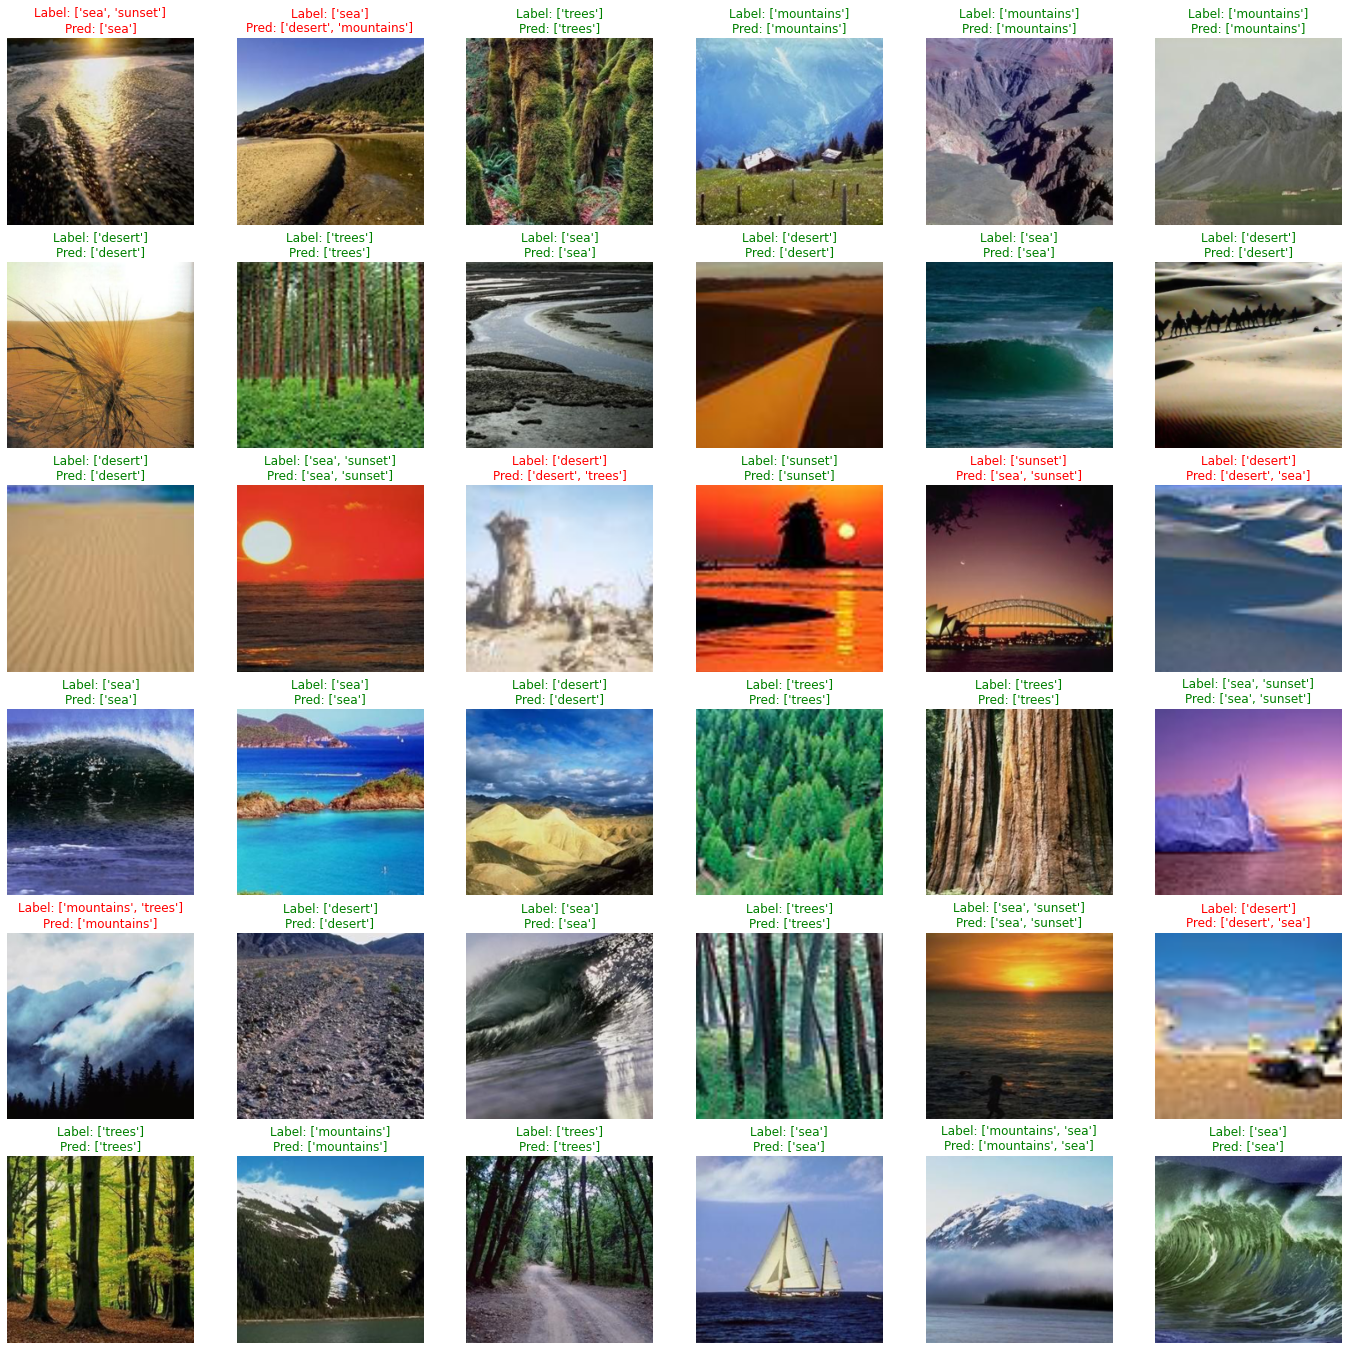

In [19]:
fig, axes = plt.subplots(6, 6, figsize=(24, 24))
for img, label, pred, ax in zip(feature, target, preds, axes.flatten()):
    ax.imshow(inverse_norm(img).permute(1, 2, 0).cpu())
    font = {"color": 'r'} if (pred != label).any() else {"color": 'g'}        
    label, pred = convert_to_label(label), convert_to_label(pred)
    ax.set_title(f"Label: {label}\nPred: {pred}", fontdict=font);
    ax.axis('off');

In [20]:
!zip -r model.zip /content/model

  adding: content/model/ (stored 0%)
  adding: content/model/weights_best.pth (deflated 8%)
  adding: content/model/configs.pth (deflated 12%)
  adding: content/model/logs.pth (deflated 7%)


In [21]:
!ls -la

total 33324
drwxr-xr-x 1 root root     4096 Jun 10 14:40 .
drwxr-xr-x 1 root root     4096 Jun 10 14:04 ..
drwxr-xr-x 1 root root     4096 Jun  8 16:15 .config
drwxr-xr-x 4 root root     4096 Jun 10 14:11 data
drwxrwxr-x 3 root root     4096 Sep  4  2019 __MACOSX
drwxr-xr-x 2 root root     4096 Jun 10 14:12 model
-rw-r--r-- 1 root root  8419347 Jun 10 14:40 model.zip
-rw-r--r-- 1 root root 25672319 Jun 10 14:11 panorama.zip
drwxr-xr-x 1 root root     4096 May 29 18:19 sample_data
